In [1]:
import os
from alarms import *
print(pio.renderers)

Renderers configuration
-----------------------
    Default renderer: 'plotly_mimetype+notebook'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery']



### Enter Input Variables to the script

In [2]:
input_fname = "formatted-pre-2-haziran2019.csv"
include_iops = True
num_top_sensors = 15 # include the sensors top x sensors which trigger most alarms
num_top_conditions = 10
chatter_filter = 100 # only consider those sources in which chattering happend more than these many times 

In [3]:
path = "./data/new/"
df = pd.read_csv(path + input_fname,low_memory=False, parse_dates = ["StartTime", "EndTime"])
# print("Before:",df["SourceName"].unique())
maskSourceNames(df)
# print("After:",df["SourceName"].unique())
df["Time"] = df["Time"].apply(lambda d: datetime.strptime(d,"%H:%M").time())
df.head(5)

,SourceName,StartTime,EndTime,Message,RecoveryMessage,Quality,Condition,Mask,NewState,Status,TimeDelta,Year,Month,MonthDay,WeekDay,Time,Hour,Minute
0,S1,2019-05-31 00:00:01,2019-05-31 00:00:03,48TIC2026 E208 CKS TEMIZ MDEA PV = -4.9 C VEL+,48TIC2026 E208 CKS TEMIZ MDEA PV = -5.5 C VEL+...,192,VEL+,193,3,1,2.0,2019,5,31,Friday,00:00:00,0,0
1,S1,2019-05-31 00:00:03,2019-05-31 00:00:04,48TIC2026 E208 CKS TEMIZ MDEA PV = -5.5 C VEL-,48TIC2026 E208 CKS TEMIZ MDEA PV = -5.3 C VEL-...,192,VEL-,193,3,1,1.0,2019,5,31,Friday,00:00:00,0,0
2,S1,2019-05-31 00:00:05,2019-05-31 00:00:06,48TIC2026 E208 CKS TEMIZ MDEA PV = -4.9 C VEL+,48TIC2026 E208 CKS TEMIZ MDEA PV = -5.1 C VEL+...,192,VEL+,193,3,1,1.0,2019,5,31,Friday,00:00:00,0,0
3,S1,2019-05-31 00:00:10,2019-05-31 00:00:11,48TIC2026 E208 CKS TEMIZ MDEA PV = -4.9 C VEL+,48TIC2026 E208 CKS TEMIZ MDEA PV = -5.0 C VEL+...,192,VEL+,193,3,1,1.0,2019,5,31,Friday,00:00:00,0,0
4,S1,2019-05-31 00:00:20,2019-05-31 00:00:21,48TIC2026 E208 CKS TEMIZ MDEA PV = -5.4 C VEL-,48TIC2026 E208 CKS TEMIZ MDEA PV = -5.3 C VEL-...,192,VEL-,193,3,1,1.0,2019,5,31,Friday,00:00:00,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 919455 entries, 0 to 919454
Data columns (total 18 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   SourceName       919455 non-null  object        
 1   StartTime        919455 non-null  datetime64[ns]
 2   EndTime          919455 non-null  datetime64[ns]
 3   Message          919455 non-null  object        
 4   RecoveryMessage  919455 non-null  object        
 5   Quality          919455 non-null  int64         
 6   Condition        919455 non-null  object        
 7   Mask             919455 non-null  int64         
 8   NewState         919455 non-null  int64         
 9   Status           919455 non-null  int64         
 10  TimeDelta        919455 non-null  float64       
 11  Year             919455 non-null  int64         
 12  Month            919455 non-null  int64         
 13  MonthDay         919455 non-null  int64         
 14  WeekDay          919

### Selecting the Sensors which trigger most number of alarms

In [5]:
temp_s = df['SourceName'].value_counts()
# temp_s,temp_s.keys()[:10], temp_s.values[:10],
top_sources = temp_s.keys()[:num_top_sensors]
df_of_top_x_sensors = df.loc[df['SourceName'].isin(top_sources)]
df_of_top_x_sensors.shape,df.shape, df.shape[0]-df_of_top_x_sensors.shape[0],temp_s

((901256, 18),
 (919455, 18),
 18199,
 S1      578192
 S2      224226
 S3       37013
 S4       11266
 S5       10786
          ...  
 S355         1
 S381         1
 S411         1
 S315         1
 S413         1
 Name: SourceName, Length: 445, dtype: int64)

### Selecting top conditions which occured most of the time in alarms

In [6]:

temp_s = df['Condition'].value_counts()
top_conditions = temp_s.keys()[:num_top_conditions]
df_of_top_x_conditions = df.loc[df['Condition'].isin(top_conditions)]
df_of_top_x_conditions.shape,df.shape, df.shape[0]-df_of_top_x_conditions.shape[0],temp_s


((912934, 18),
 (919455, 18),
 6521,
 VEL+    298501
 VEL-    296377
 IOP     250664
 LLL      21934
 LO       13131
 LL       10146
 ALM       7614
 HTRP      5925
 HHH       5755
 HI        2887
 IOP-      2714
 LTRP      1675
 HH         746
 ANS-       694
 CNF        444
 DV-        164
 DV+         65
 ANS+        15
 MHI          2
 OOP          1
 MLO          1
 Name: Condition, dtype: int64)

# StartTime 

The following graph shows all the alarms triggered in this dataset. The x-axis represents the activation time of an alarm, and the y-axis shows the duration (i.e., TimeDelta= StartTime - EndTime) of the corresponding activation. As we can see that most of the alarms deactivated within 20 seconds (it will be more clear in followings sections).

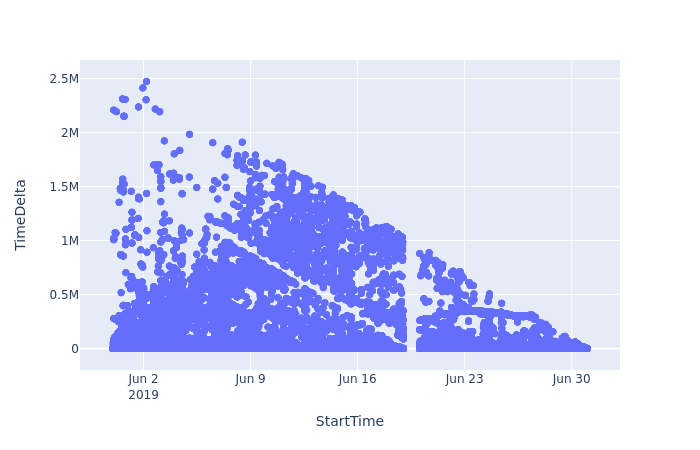

In [7]:
fig = px.scatter(df, x="StartTime", y="TimeDelta",render_mode="webgl")
fig.show(renderer="png")

# Box Plot of  TimeDelta for all alarms
This is one of the most important box plots in the whole analysis. It will help us to determine the threshold for TimeDelta. If the duration between activation and deactivation (i.e., TimeDelta = Deactivation - Activation) is less than the threshold then we will not transmit such alarm to the historian. From the following box plot, we can see that the first quartile (q1) is equal to 16 seconds which means if we set the threshold constant equals to 16 seconds we will directly reduce 25% of the communications between the DCS systems and Historian server. Similarly, if we set threshold constant to 29 seconds (i.e., q2 or median value) the 50 % of the storage & and communication will be reduced.  
**Questions:**
* We need more data to determine the threshold constant value. Can I get more data of the same plant? For example, 1 year or  6 months.
* Can I choose threshold value equals to 29 seconds?

**Note: If hover the mouse over any graph it will show the values.**

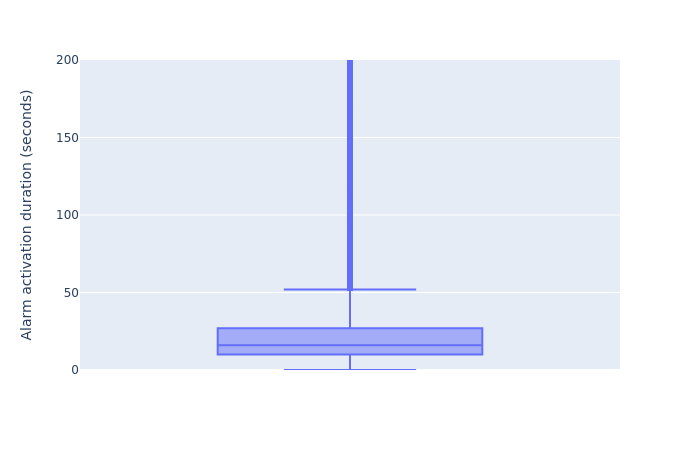

In [8]:
fig = px.box(df, y="TimeDelta")
fig.update_yaxes(range=[0,200])
fig.update_yaxes(title_text='Alarm activation duration (seconds)')
fig.show(renderer="png")

# SourceName Analysis

From the first histograms, we can see that "47TI931" triggered the most number of alarms. Additionally, all the alarms are related to “IOP” condition. 

**Questions** 
* Why so many communications problems occur? Is it normal?


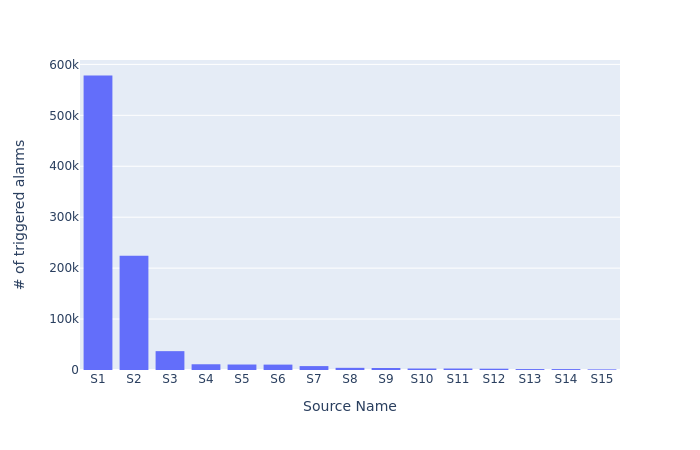

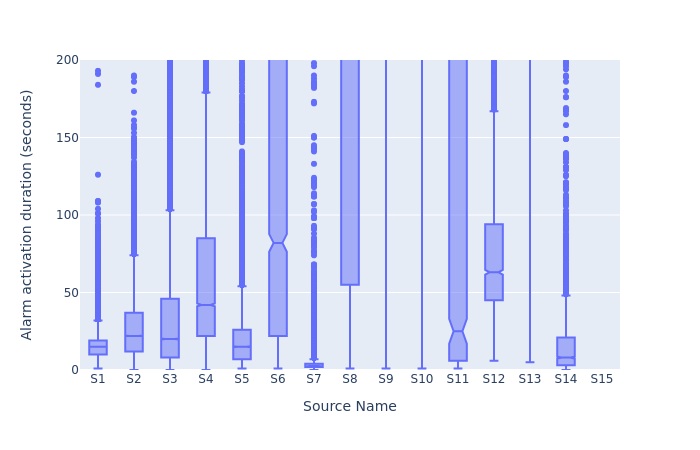

In [9]:
fig = px.histogram(df_of_top_x_sensors, x = "SourceName")
fig.update_xaxes(title_text='Source Name')
fig.update_yaxes(title_text='# of triggered alarms')
fig.show(renderer="png")

# fig = px.histogram(df, x = "SourceName", color="Condition",  barmode='group')
# fig.update_layout(title="Number of times a condition occured for a SourceName.")
# fig.show()

fig = px.box(df_of_top_x_sensors, x= "SourceName", y="TimeDelta",notched=True)
fig.update_yaxes(range=[0, 200], title_text='Alarm activation duration (seconds)')
fig.update_xaxes(title_text='Source Name')
# fig.update_layout(title="Box Plot of TimeDelats (Deactivaion - Activation) for each SourceName")
fig.show(renderer="png")
# fig.show(renderer="png")


# Conditions Analysis

As we can see from the following graphs, the most frequent alarms are related to communication problems. For instance, IOP condition occurred more 191 thousand time. Additionally, from the box plot, we can see that that durations (i.e., timedelta = deactivation time - activation time)  of IOP alarms are shorter.

**Conclusion:** IOP communications can discard easily as it just represent only the communication issue between the field device and the DCS system. So if we discard such alarms we reduce the communication between the DCS system and historian server to a few hundreds instead of thousands. 

**Questions:**
* Why the Vel+ and Vel- conditions are lesser than compared to other conditions? Because they were the most in 1-day data (old data). Is it normal?
* Whether my conclusion is correct or not? 


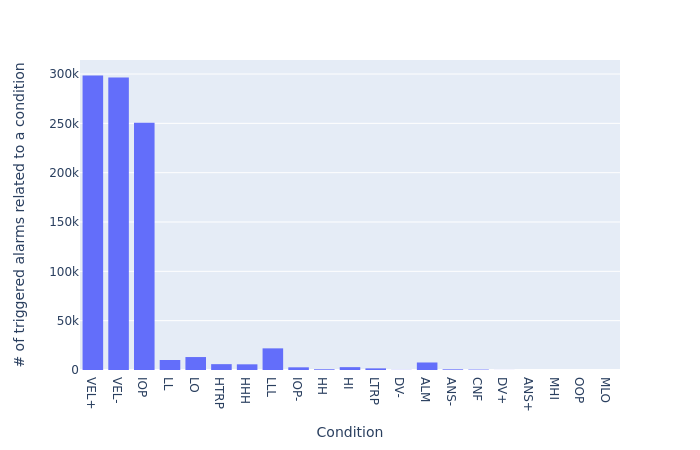

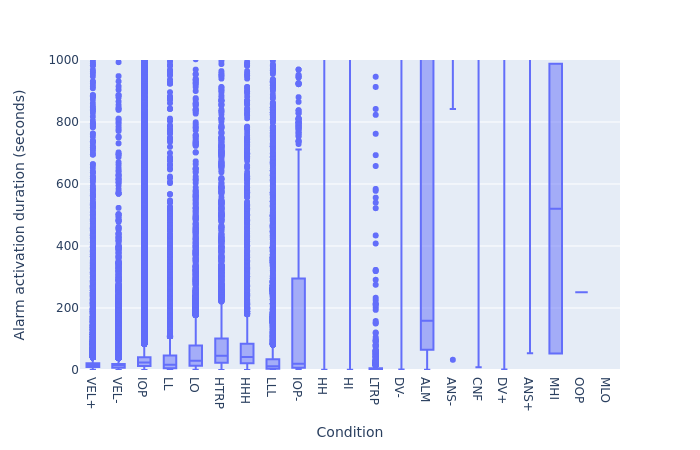

In [10]:
fig = px.histogram(df, x = "Condition")
fig.update_xaxes(title_text='Condition')
fig.update_yaxes(title_text='# of triggered alarms related to a condition')
fig.show(renderer="png")


# No need to use top_x_conditions .. 
fig = px.box(df, x= "Condition", y="TimeDelta")
fig.update_yaxes(range=[0, 1000], title_text='Alarm activation duration (seconds)')
fig.show(renderer="png")

### Condtions Occuring on each day of Week

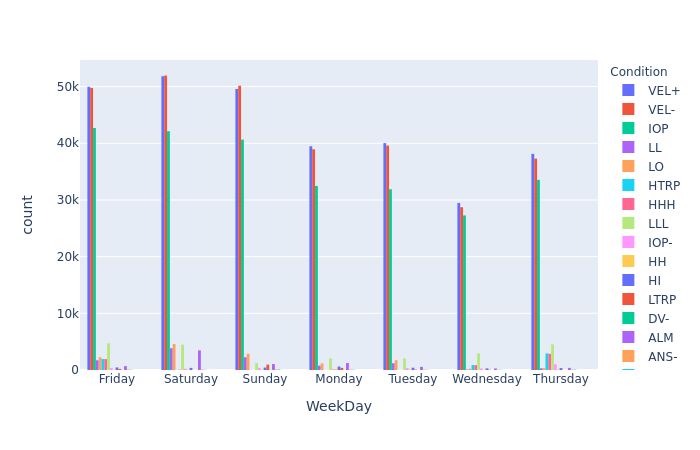

In [11]:
fig = px.histogram(df, x="WeekDay", color="Condition",  barmode='group')
fig.show(renderer="png")

In [12]:
# sources = {} # contains each unique sourcename as key and corresponding alarms in a list
# for sname in df["SourceName"].unique():
#     sources[sname] =  []
# temp_dict = None
# for i in range(df.shape[0]):
#     temp_dict = {}
#     for key in df.columns:
#         temp_dict[key] = df[key][i]
#     sources[df["SourceName"][i]].append(temp_dict)

In [13]:
# temp =  df.loc[df['SourceName'].isin(["S1"])]
# len(temp.to_dict(orient="records"))

# Chattering 
If an alarm from the same source is triggered 3 times or less then such situation of chattering is considered normal.  However, from the following the histograms, we can see that thousands of alarms are triggered more than thrice in most of the sensors. For instance, consider "47TI931A", it chatters 6 times in a minute more than 31 thousand times. 

**Note:  x-axis represents the number of times an alarm chatter in the duration of one minute. The y-axis represents how many times such conditions (i.e., chatters) occur.** 

**Conclusion:** Such conditions (in which an alarm is triggered more than 3 times in a minute) are abnormals. So, if we detect such conditions at the edge it may help to do.... [list the usages].
 
**Questions:** 
* Is my conclusion correct? 
* What are the use cases if we detect chatters in real-time? 
* How too much chattering effect system performance?

check it [('S1', 40209, 537976), ('S2', 34645, 182638), ('S3', 3397, 31105), ('S4', 845, 10189), ('S5', 515, 10095), ('S6', 859, 4777), ('S7', 413, 7087), ('S9', 169, 607), ('S10', 235, 1457), ('S11', 297, 1084), ('S12', 321, 2046), ('S13', 146, 565), ('S14', 209, 1346)]


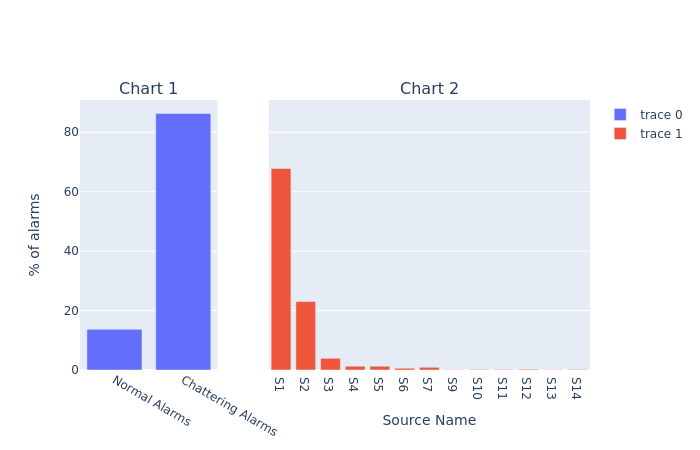

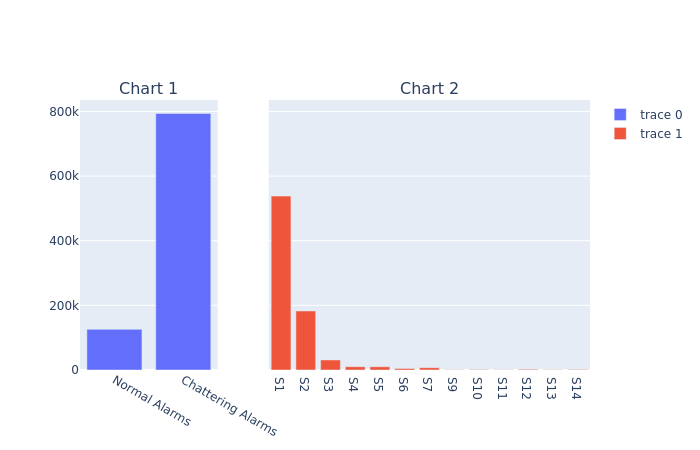

In [14]:
x_axis = []
y_axis = []
chatters = []
total_alarms_in_all_chatters = 0


for sname in df["SourceName"].unique():
    s_alarms =  df.loc[df['SourceName'].isin([sname])]
    s_alarms = s_alarms.to_dict(orient="records")
    chats = findChatterings(s_alarms)
    chatters.append((sname, len(chats.keys()), sum([d["count"] for d in chats.values()])))
    total_alarms_in_all_chatters += sum([d["count"] for d in chats.values()]) 

chatters = list(filter(lambda arg: arg[1]>chatter_filter, chatters)) # alarms which chattered more than chatter_filter times
print("check it",chatters)


# Graph of Percentage
fig = make_subplots(rows=1, cols=2, column_widths=[0.3, 0.7], shared_yaxes=True,subplot_titles=("Chart 1", "Chart 2"))
x_axis = ["Normal Alarms", "Chattering Alarms"]
y_axis = [df.shape[0]-total_alarms_in_all_chatters ,total_alarms_in_all_chatters]
y_axis = list(map(lambda x: (x/df.shape[0])*100, y_axis))

trace1 = go.Bar(x=x_axis, y=y_axis, text=x_axis)
trace2 = go.Bar(x=[t[0] for t in chatters], y=[(t[2]/total_alarms_in_all_chatters)*100 for t in chatters])

fig.add_trace(trace1, row=1, col=1)
fig.add_trace(trace2, row=1, col =2)
fig.update_layout(height=600, width=1000)
fig.update_yaxes(title_text='% of alarms', row=1, col=1)
fig.update_xaxes(title_text='Source Name', row=1, col=2)
fig.show(renderer="png")

#Graph of Counting
fig = make_subplots(rows=1, cols=2, column_widths=[0.3, 0.7], subplot_titles=("Chart 1", "Chart 2") ,shared_yaxes=True)

x_axis = ["Normal Alarms", "Chattering Alarms"]
y_axis = [df.shape[0]-total_alarms_in_all_chatters ,total_alarms_in_all_chatters]
# y_axis = list(map(lambda x: (x/df.shape[0])*100, y_axis))

trace1 = go.Bar(x=x_axis, y=y_axis, text=x_axis)
trace2 = go.Bar(x=[t[0] for t in chatters], y=[t[2] for t in chatters])

fig.add_trace(trace1, row=1, col=1)
fig.add_trace(trace2, row=1, col =2)
fig.update_layout(height=600, width=1000)
fig.show(renderer="png")

# fig = px.histogram(df, x="WeekDay", color="Condition",  barmode='group')
# fig.show(renderer="png")


# check it [('S1', 40209, 537976), ('S2', 34645, 182638), ('S3', 3397, 31105), ('S4', 845, 10189), ('S5', 515, 10095), ('S6', 859, 4777), ('S7', 413, 7087), ('S8', 67, 226), ('S9', 169, 607), ('S10', 235, 1457), ('S11', 297, 1084), ('S12', 321, 2046), ('S13', 146, 565), ('S14', 209, 1346), ('S19', 83, 441), ('S20', 83, 441), ('S25', 60, 402), ('S29', 50, 225), ('S36', 34, 112)]

# Time Between form one Deactivation to Next Activation for whole Data

In this section, I tried to find the time between 1 deactivation to next activation. In ideal scenario, there should be 1 alarm per minute. However, when I took the time difference between 1 deactivation to the next activation of any alarm the difference (delta) was mostly under 10 seconds which means that a huge number alarms are generated in 1 minute.

**Note: The x-axis represents the time delta (i.e., the time difference between deactivation and activation of an alarm), while the y-axis represents the frequency (count) of corresponding deltas.**

**Questions:**  
* Are my observations correct? If not please let me know what should I do to cross-check my results
* If my observations are correct then what kind of conclusions I can draw from this graph?


In [15]:
alarms = df.to_dict(orient="records")
durations = frequencyOfAlarmsActivated(alarms)
d = {}
for v in durations:
#     if v < 200:
    d[v] = 0

for v in durations:
#     if v < 200:
    d[v] +=1

counts = [v for v in d.values()]
deltas = [k for k in d.keys()]

for delta in sorted(d.keys()):
    print((delta, d[delta]), end=" ")
# (0.0, 404001) (1.0, 142133) (2.0, 171784) (3.0, 58800) (4.0, 52553) (5.0, 31374) (6.0, 21085) (7.0, 12020) (8.0, 7067) (9.0, 6146) (10.0, 3887) (11.0, 3134) (12.0, 2634) (13.0, 1276) (14.0, 962) (15.0, 188) (16.0, 236) (17.0, 75) (18.0, 30) (19.0, 14) (20.0, 11) (21.0, 13) (22.0, 9) (23.0, 4) (24.0, 2) (25.0, 4) (26.0, 1) (28.0, 1) (174.0, 1) (330.0, 1) (90403.0, 1) (90404.0, 1) 

(0.0, 404001) (1.0, 142133) (2.0, 171784) (3.0, 58800) (4.0, 52553) (5.0, 31374) (6.0, 21085) (7.0, 12020) (8.0, 7067) (9.0, 6146) (10.0, 3887) (11.0, 3134) (12.0, 2634) (13.0, 1276) (14.0, 962) (15.0, 188) (16.0, 236) (17.0, 75) (18.0, 30) (19.0, 14) (20.0, 11) (21.0, 13) (22.0, 9) (23.0, 4) (24.0, 2) (25.0, 4) (26.0, 1) (28.0, 1) (174.0, 1) (330.0, 1) (90403.0, 1) (90404.0, 1) 

In [16]:
# fig = px.bar(x=deltas, y = counts)
# fig.show(render="png")

# End